In [43]:
import sys
sys.path.append("../../../")

import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from experiments.assumptions.flat_output_space.script import get_euclideaness
from riemannian_geometry.computations.sample import sample_layers

from models.supervised.mlp.model import MLP
from models.data.sklearn_datasets import MoonDataset, SpiralDataset, BlobsDataset, CirclesDataset

models_path = "../../../models/supervised/mlp/saved_models"
# We want to measure the ``flatness'' of the output space of a neural network
# to then use the identity for sectional curvature as well as providing supporting
# evidence for the manifold hypothesis.

# We will use 3 methods to estimate the Riemann metric taken from https://github.com/georgiosarvanitidis/geometric_ml
# 1. Local PCA
# 2. 

In [44]:
np.random.seed(2)
torch.manual_seed(2)

In [45]:
mode = 'moon'
size = "skinny"
epoch = 199
if mode == 'moon':
    dataset = MoonDataset(n_samples=1000, noise=0.01)
elif mode == 'blobs':
    dataset = BlobsDataset(n_samples=1000, noise=0.01)
elif mode == 'spiral':
    dataset = SpiralDataset(n_samples=1000, noise=0.01)
elif mode == 'circles':
    dataset = CirclesDataset(n_samples=1000, noise=0.01)


if size == "skinny":
    model = MLP(2,7,2,2)
    full_path = f'{models_path}/2_wide/mlp_{mode}/model_{epoch}.pth'
elif size == "overfit":
    model = MLP(2,7,2,1)
    full_path = f'{models_path}/overfit/mlp_{mode}/model_{epoch}.pth'
else:
    model = MLP(2,7,10,2)
    full_path = f'{models_path}/vanilla/mlp_{mode}/model_{epoch}.pth'
model.load_state_dict(torch.load(full_path))


<All keys matched successfully>

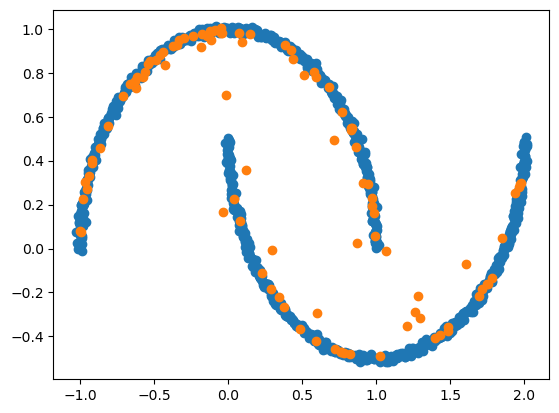

In [10]:
model = MLP(2,7,2,2)

full_path = f'{models_path}/2_wide/mlp_{mode}/model_{199}.pth'
model.load_state_dict(torch.load(full_path))
model.forward(torch.from_numpy(dataset.X).float(), save_activations=True)
activations = model.activations
if activations[-1].shape[1] == 1:
    activations = activations[:-1]
samples = sample_layers(activations, num_samples=100)

import matplotlib.pyplot as plt
plt.scatter(activations[0][:, 0], activations[0][:, 1])
plt.scatter(samples[0][:, 0], samples[0][:, 1])

plt.show()


In [4]:
res = []
for epoch in tqdm(range(0, 200, 5)):
    full_path = f'{models_path}/2_wide/mlp_{mode}/model_{epoch}.pth'
    model.load_state_dict(torch.load(full_path))
    model.forward(torch.from_numpy(dataset.X).float(), save_activations=True)
    activations = model.activations
    samples = sample_layers(activations, num_samples=100)
    euclidean = get_euclideaness(activations, samples)
    res.append(euclidean)

res = np.array(res)

K = res.shape[1]
for i in range(K):
    plt.plot(res[:, i], label=f'Layer {i}')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Euclideaness')
plt.title("Measuring Flatness of Skinny Model")
plt.savefig("figures/Euclideness_2_wide.png")


100%|██████████| 40/40 [05:53<00:00,  8.84s/it]


In [ ]:
res = []
model = MLP(2,7,2,1)
model.eval()

for epoch in tqdm(range(999, 10000, 1000)):
    full_path = f'{models_path}/overfit/mlp_{mode}/model_{epoch}.pth'
    model.load_state_dict(torch.load(full_path))
    model.forward(torch.from_numpy(dataset.X).float(), save_activations=True)
    activations = model.activations
    if activations[-1].shape[1] == 1:
        activations = activations[:-1]
    samples = sample_layers(activations, num_samples=100)
    euclidean = get_euclideaness(activations, samples)
    res.append(euclidean)

res = np.array(res)

K = res.shape[1]
for i in range(K):
    plt.plot(res[:, i], label=f'Layer {i}')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Euclideaness')
plt.title("Measuring Flatness of Overfit Model")
plt.savefig("figures/Euclideness_overfit.png")

In [46]:
from riemannian_geometry.computations.pullback_metric import pullback_metric_surface

In [53]:
N = 50
layer_g, layer_xy_grid = pullback_metric_surface(model, dataset.X, N=N, method="layer_wise")
output_g, output_xy_grid = pullback_metric_surface(model, dataset.X, N=N, method="output_wise")

In [126]:
from riemannian_geometry.computations.riemann_metric import LocalDiagPCA
from riemannian_geometry.computations.pullback_metric import compute_jacobian_multi_layer
from riemannian_geometry.computations.sample import sample_layers
from utils.plotting.mesh import generate_lattice



In [ ]:
sample_points = sample_layers(activations, num_samples=100)



In [132]:
import numpy as np
import sympy as sp

def fd_christoffel(g_func, f, x, epsilon=1e-5):
    """Compute the Christoffel symbols for a non-constant metric g using finite differences."""
    # Evaluate the metric at the point x
    g = g_func(f(x))
    dim = g.shape[0]
    Gamma = np.zeros((dim, dim, dim))
    
    # Inverse of the metric tensor
    g_inv = np.linalg.inv(g)
    
    # Compute the Christoffel symbols using finite differences
    for k in range(dim):
        e_k = np.zeros(dim)
        e_k[k] = 1
        
        # Evaluate the metric at perturbed points
        g_forward = g_func(f(x + epsilon * e_k))
        g_backward = g_func(f(x - epsilon * e_k))
        for i in range(dim):
            for j in range(dim):
                partial_g_ij_k = (g_forward[i, j] - g_backward[i, j]) / (2 * epsilon)
                Gamma[k, i, j] = 0.5 * np.sum(g_inv[k, :] * 
                                              (partial_g_ij_k + 
                                               (g_forward[i, :] - g_backward[i, :]) +
                                               (g_forward[:, j] - g_backward[:, j])))
    
    return Gamma


def compute_riemann_curvature_tensor(g, x_coords, Gamma):
    n = len(x_coords)
    x = sp.symbols('x0:%d' % n)
    
    # Compute the inverse of the metric tensor
    # Compute the Riemann curvature tensor
    R = np.empty((n, n, n, n), dtype=object)
    for l in range(n):
        for i in range(n):
            for j in range(n):
                for k in range(n):
                    R[l, i, j, k] = (
                        sp.diff(Gamma[l, j, k], x[i]) -
                        sp.diff(Gamma[l, i, k], x[j]) +
                        sum(Gamma[l, m, i] * Gamma[m, j, k] - Gamma[l, m, j] * Gamma[m, i, k] for m in range(n))
                    )
    
    # Substitute x_coords into R
    R_value = np.empty((n, n, n, n))
    for l in range(n):
        for i in range(n):
            for j in range(n):
                for k in range(n):
                    R_value[l, i, j, k] = R[l, i, j, k].subs({x[idx]: val for idx, val in enumerate(x_coords)})
    
    return R_value


model = MLP(2,7,2,2)
full_path = f'{models_path}/2_wide/mlp_{mode}/model_{epoch}.pth'
model.load_state_dict(torch.load(full_path))

model.forward(torch.from_numpy(dataset.X).float(), save_activations=True)
activations = model.activations
activations_np = [activation.detach().numpy() for activation in activations]
manifold = LocalDiagPCA(activations_np[-2], sigma=0.05, rho=1e-3)
model.layers = model.layers[:-1]
lattice_input_space = generate_lattice(activations_np[0], N=50)
model.forward(torch.from_numpy(lattice_input_space).float(), save_activations=True)
samples_points_lattice = model.activations

# Test using a sample metric tensor (2D Euclidean metric for simplicity)
res = []
for layer in range(-2, -1):
    s = []
    output, g_M = pulled_back_metric(samples_points_lattice[layer], model, layer)
    for indx in range(len(output)):
        g = sp.Matrix(g_M[0])
        x_coords = output[0]
        R_value = compute_riemann_curvature_tensor(g, x_coords)
        #if not np.array_equal(R_value.ravel(), np.zeros_like(R_value.ravel())):
        #    print(R_value)
        s.append(np.sum(R_value))
    res.append(s)


In [174]:

model = MLP(2,7,2,2)
full_path = f'{models_path}/2_wide/mlp_{mode}/model_{epoch}.pth'
model.load_state_dict(torch.load(full_path))

model.forward(torch.from_numpy(dataset.X).float(), save_activations=True)
activations = model.activations
activations_np = [activation.detach().numpy() for activation in activations]
manifold = LocalDiagPCA(activations_np[-1], sigma=0.05, rho=1e-3)

x = model.forward(torch.tensor(np.array([[0, 0]])).float()).detach().numpy()
func = model.layers[-1]
g_func = lambda x: np.diagflat(manifold.metric_tensor(x.reshape(-1, 1)))
layer_func = lambda x: model.forward_layers(torch.from_numpy(x).float().unsqueeze(0), -1).detach().numpy().squeeze(0)

fd_christoffel(g_func, layer_func, x, epsilon=1e-4)

array([[[-1.51610060e+00, -3.03098880e-04],
        [-3.03098880e-04, -2.56060053e-01]],

       [[ 2.24867497e+01,  3.07808360e-04],
        [ 3.07808360e-04,  1.53965741e+00]]])

In [143]:
def pullback_christofell(Gamma_N, J):
    """
    Compute the Christoffel symbols in M given the Christoffel symbols in N,
    the Jacobian J of the diffeomorphism f at point p, and the metric g at f(p).
    
    Parameters:
    - Gamma_N: Christoffel symbols in N.
    - J: Jacobian of the diffeomorphism f at point p.
    - g_N_at_f: Metric g evaluated at f(p).
    
    Returns:
    - Gamma_M: Christoffel symbols in M.
    """
    
    dim_M, dim_N = J.shape
    J_inv = np.linalg.inv(J)
    
    # Compute the second derivatives of the map f using finite differences
    epsilon = 1e-5
    second_derivatives = np.zeros((dim_M, dim_N, dim_N))
    for k in range(dim_M):
        e_k = np.zeros(dim_M)
        e_k[k] = epsilon
        J_forward = (J + e_k[:, np.newaxis])  # Perturb in the k-th direction
        J_backward = (J - e_k[:, np.newaxis])
        for i in range(dim_N):
            for j in range(dim_N):
                second_derivatives[k, i, j] = (J_forward[i, j] - J_backward[i, j]) / (2 * epsilon)
    
    # Use the transformation formula to compute the Christoffel symbols in M
    Gamma_M = np.zeros((dim_M, dim_M, dim_M))
    for k in range(dim_M):
        for i in range(dim_M):
            for j in range(dim_M):
                Gamma_M[k, i, j] = sum(
                    J_inv[k, l] * (
                        Gamma_N[l, m, n] * J_inv[m, i] * J_inv[n, j] +
                        second_derivatives[l, i, j]
                    )
                    for l in range(dim_N)
                    for m in range(dim_N)
                    for n in range(dim_N)
                )
    
    return Gamma_M

# Test with a simple example
Gamma_N_example = np.array([[[0.1, 0.2], [0.3, 0.4]], [[0.5, 0.6], [0.7, 0.8]]])
J_example = np.array([[2, 0], [0, 2]])
g_N_at_f_example = np.array([[2, 0], [0, 3]])

Gamma_M_example = transform_christoffel_symbols(Gamma_N_example, J_example, g_N_at_f_example)
Gamma_M_example


NameError: name 'transform_christoffel_symbols' is not defined